In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

###### 【問題1】全結合層のクラス化

In [4]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dZ = 0
        self.dA = 0
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        # 更新
        self = self.optimizer.update(self)
        return dZ

###### 【問題2】初期化方法のクラス化

In [5]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

###### 【問題3】最適化手法のクラス化

In [6]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0]
        
        return layer

###### 【問題4】活性化関数のクラス化

In [7]:
class Sigmoid:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _func_diff(self, X):
        return (1 - self._func(X)) * self._func(X)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [8]:
class Tanh:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.tanh(X)
    
    def _func_diff(self, X):
        return 1 - (self._func(X))**2
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [9]:
class softmax:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
        self.pred = 0
    
    def _func(self, X):
        X = X - np.max(X)
        tmp = np.exp(X)
        denominator = np.sum(tmp, axis=1)
        output = tmp / denominator[:, np.newaxis]
        return output
    
    def _func_diff(self, X):
        return X
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        self.pred = A
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = self.pred - dA
        
        return dZ

###### 【問題5】ReLUクラスの作成

In [10]:
class ReLU:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.maximum(0, X)
    
    def _func_diff(self, X):
        return np.where( x > 0, 1, 0)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

###### 【問題6】重みの初期値

In [11]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [12]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

###### 【問題7】最適化手法

In [13]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #dA, dWを更新＆保存
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

###### DNN Class

In [14]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier():
    """
    ディープニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, n_epoch, batch_size, dnn_design=default_dnn_design, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.dnn_design = dnn_design
        self.loss = 0
        self.loss_val = 0
        self.activation_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        self.affine_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        self.n_layer = self.dnn_design.get('total_layer')
        
        #各インスタンスを生成
        #initializerインスタンス
        if self.dnn_design.get('initializer') is 'XavierInitializer':
            self.initializer = XavierInitializer()
        elif self.dnn_design.get('initializer') is 'HeInitializer':
            self.initializer = HeInitializer()
        elif self.dnn_design.get('initializer') is 'SimpleInitializer':
            self.initializer = SimpleInitializer(self.dnn_design.get('initializer_sigma'))
        else:
            self.initializer = SimpleInitializer()
            
        #optimizerインスタンス
        if self.dnn_design.get('optimizer') is 'SGD':
            self.optimizer = SGD(self.dnn_design.get('learning_rate'))
        elif self.dnn_design.get('optimizer') is 'AdaGrad':
            self.optimizer = AdaGrad(self.dnn_design.get('learning_rate'))
        else:
            self.optimizer = SGD(self.dnn_design.get('learning_rate'))
            
        #layerインスタンス
        print("DNN layer design")
        for i in range(self.n_layer):
            #layer designから各層のnode情報を取り出しaffine結合の関数インスタンスを作る
            key1 = "node_layer{}".format(i)
            key2 = "node_layer{}".format(i+1)
            n_nodes1 = self.dnn_design.get(key1)
            n_nodes2 = self.dnn_design.get(key2)
            self.affine_func[i] = FC(n_nodes1, n_nodes2, self.initializer, self.optimizer)
            
            #layer designから各層の活性化関数情報を取り出し活性化関数インスタンスを作る
            key3 = "func_layer{}".format(i+1)            
            if self.dnn_design.get(key3) is 'sigmoid':
                self.activation_func[i] = Sigmoid()
            elif self.dnn_design.get(key3) is 'tanh':
                self.activation_func[i] = Tanh()
            elif self.dnn_design.get(key3) is 'ReLU':
                self.activation_func[i] = ReLU()
            elif self.dnn_design.get(key3) is 'softmax':
                self.activation_func[i] = softmax()
            else:
                self.activation_func[i] = Sigmoid()
                
            print("layer{} : Func={} Node={}".format(i+1, 
                                            self.dnn_design.get(key3),
                                            self.dnn_design.get(key2)
                                            ))
        
    def _crossentropy(self, y_pred, y):
        #クロスエントロピーを計算する
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def fit(self, X, y, X_val=None, y_val=None):
        #lossの記録用の配列を用意
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                #Forwardの計算
                for layer in range(self.n_layer):
                    X = self.affine_func[layer].forward(X)
                    X = self.activation_func[layer].forward(X)
                
                #Loss計算
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                #Backwardの計算
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    dz = self.activation_func[layer].backward(dz)
                    dz = self.affine_func[layer].backward(dz)
                
                loop_count += 1
                
            #Epoch毎のLoss計算結果表示
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch:{} Loss:{} Loss(val):{}".format(i, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            X = self.affine_func[layer].forward(X)
            X = self.activation_func[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            X = self.affine_func[layer].forward(X)
            X = self.activation_func[layer].forward(X)       
        
        return X

#### 試しに動かす

In [15]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.4)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

Using TensorFlow backend.


(36000, 784)
(24000, 784)


In [16]:
#DNNデザイン

#関数:tanh, ReLU, sigmoid, softmax
dnn_layer_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':784,
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'HeInitializer',
    'initializer_sigma':0.01,
    'optimizer':'AdaGrad',
}

In [22]:
dnn_clf = ScratchDeepNeuralNetrowkClassifier(20, 10, dnn_layer_design, False)

DNN layer design
layer1 : Func=tanh Node=400
layer2 : Func=tanh Node=200
layer3 : Func=softmax Node=10


In [23]:
dnn_clf.fit(x_train, y_train, x_val, y_val)

###### 学習曲線

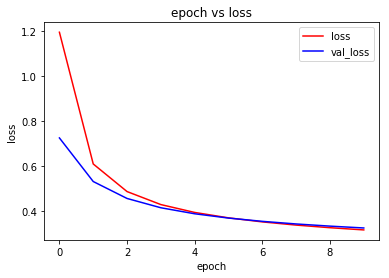

In [19]:
loss = np.array(dnn_clf.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(dnn_clf.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
#plt.yscale("Log")
plt.show()

###### 精度

In [20]:
y_pred = dnn_clf.predict(x_val)
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.907


###### 誤分類の確認

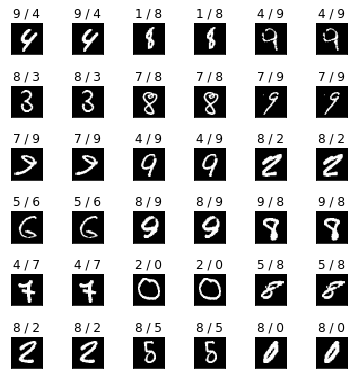

In [21]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(np.argmax(y_pred[false_list[i]]),np.argmax(y_val[false_list[i]])))
    ax.imshow(x_val.reshape(-1,28,28)[false_list[i]], cmap='gray')